In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import numpy as np
import dask
import xarray as xr
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [112]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

In [113]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
temp = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t).isel(time=[-2, -1])

In [114]:
temp, grid = add_rotated_coords(temp, θ)
temp = add_thalweg(temp)
temp = add_temp_budget(temp, grid, Γ, θ)
temp = temp.reset_coords(['Depth'])
print("Budget closes: ", check_temp_budget_closes(temp))

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Budget closes:  True


In [115]:
budget_vars = [
    'total_tendency_TH_truth', 'total_tendency_TH',
    'diff_tendency_TH', 'adv_tendency_TH',
    'conv_adv_flux_anom_TH', 'conv_vert_adv_flux_TH'
]

temp_in = irregular_section(temp[budget_vars+['THETA', 'Depth']], temp['j_thalweg'].values, width=25)
temp_out = irregular_section(temp[budget_vars+['THETA', 'Depth']], temp['j_thalweg'].values, width=25, invert_mask=True)
temp_crest = irregular_section(temp[budget_vars+['THETA', 'Depth']], temp['j_thalweg'].values, width=35, invert_mask=True)

canyon_height = temp['Depth'].max().values - (temp_crest['Depth'].mean(['XC', 'YC'], skipna=True).values)

In [116]:
Lx, Ly = temp.XC.size*dx, temp.YC.size*dy
cint = k0*Γ*np.cos(θ)*Ly*Lx
cbot = k1*Γ*np.cos(θ)*Ly*Lx

In [117]:
temp_intXY = temp[budget_vars].mean(dim='time').sum(dim=['XC','YC'], skipna=True).load()
temp_in_intXY = temp_in[budget_vars].mean(dim='time').sum(dim=['XC','YC'], skipna=True).load()
temp_out_intXY = temp_out[budget_vars].mean(dim='time').sum(dim=['XC','YC'], skipna=True).load()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/env

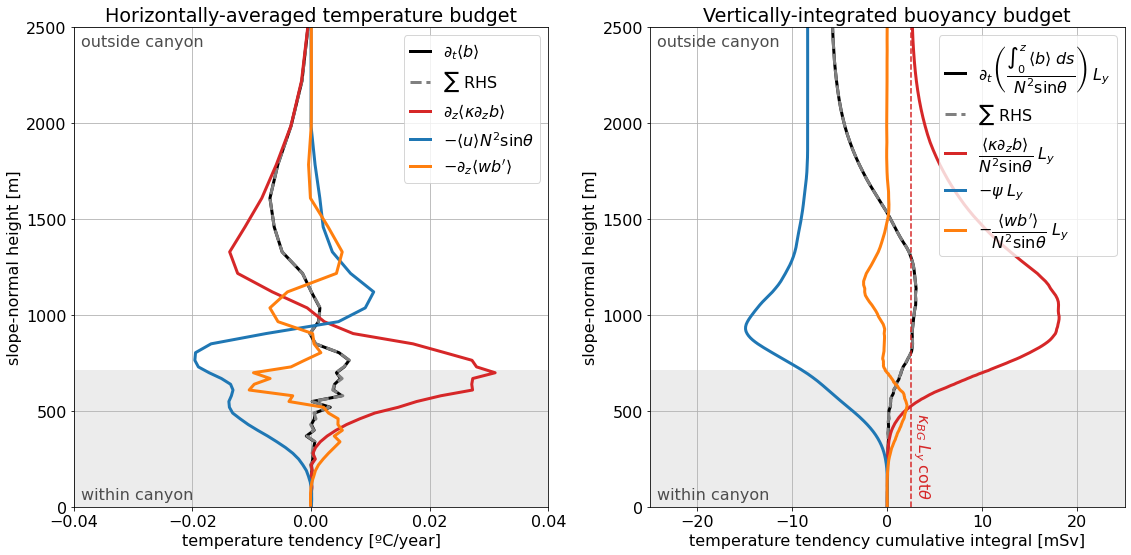

In [118]:
labels = {
    "total_tendency_TH_truth": r"$\partial_{t} \langle b \rangle$",
    "total_tendency_TH": r"$\sum$ RHS",
    "diff_tendency_TH": r"$\partial_{z} \langle \kappa \partial_{z} b \rangle$",
    "conv_adv_flux_anom_TH": r"$-\langle u \rangle N^{2} \sin{\theta}$",
    "conv_vert_adv_flux_TH": r"$-\partial_{z} \langle w b' \rangle$"
}

int_labels = {
    "total_tendency_TH_truth": r"$\partial_{t} \, \left(\dfrac{\int_{0}^{z}\, \langle b \rangle \; ds}{N^{2} \sin{\theta}} \right)\; L_{y}$",
    "total_tendency_TH": r"$\sum$ RHS",
    "diff_tendency_TH": r"$\dfrac{ \langle \kappa \partial_{z} b \rangle}{N^{2} \sin{\theta}}\; L_{y}$",
    "conv_adv_flux_anom_TH": r"$-\psi\; L_{y}$",
    "conv_vert_adv_flux_TH": r"$-\dfrac{\langle w b' \rangle}{N^{2} \sin{\theta}}\; L_{y}$"
}


fig, axes = plt.subplots(1,2, figsize=(16,8))
colors = ["k", "grey", "C3", "C0", "C1"]
for v, var in enumerate(labels.keys()):
    linestyle='-'; lw = 3;
    if var=="total_tendency_TH": linestyle="--"; lw=3;
    (temp_intXY[var]/(temp_intXY['drF']*Lx*Ly)*(86400.*365.)).coarsen(Z=5).mean().plot(ax=axes[0], y='Z', color=colors[v], label=labels[var], linestyle=linestyle, lw=lw)
    (np.cumsum(temp_intXY[var][::-1])[::-1]/(Γ*np.sin(θ)*Lx*Ly)*(Ly*1e-3)).plot(ax=axes[1], y='Z', color=colors[v], label=int_labels[var], linestyle=linestyle, lw=lw)

axes[1].axvline(cint/(Γ*np.sin(θ)*Lx*Ly)*(Ly*1e-3), linestyle='--', color='C3')
axes[1].annotate(r"$\kappa_{BG}\; L_{y}\; \cot{\theta}$", (0.55, 0.03), xycoords='axes fraction', color="C3", rotation=-90)
#axes[1].axvline(-cbot/(Γ*np.sin(θ)*Lx*Ly), linestyle=':', color='g', label=r"$\pm \kappa_{Bot} \cot{\theta}$")
#axes[1].axvline(cbot/(Γ*np.sin(θ)*Lx*Ly), linestyle=':', color='g')

axes[0].set_xlabel(r"temperature tendency [ºC/year]")
axes[0].set_title("Horizontally-averaged temperature budget")
axes[0].set_xticks(np.arange(-0.04, 0.05, 0.02))
axes[0].set_xlim([-0.04, 0.04])
axes[1].set_xlabel(r"temperature tendency cumulative integral [mSv]")
axes[1].set_title("Vertically-integrated buoyancy budget")
axes[1].set_xlim([-25, 25])

for ax in axes:
    ax.set_ylabel("slope-normal height [m]")
    ax.set_ylim([0, 2500])
    ax.grid(True)
    ax.fill_between(ax.get_xlim(), [0., 0.], canyon_height*np.array([1, 1]), lw=5., alpha=0.15, facecolor="grey")
    ax.legend(loc = "upper right", handlelength=1.25)
    ax.annotate("within canyon", xy=(0.015, 0.015), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)
    ax.annotate("outside canyon", xy=(0.015, 0.96), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)

#axes[1].tick_params(labeltop=True)
plt.tight_layout()

plt.savefig("../../figures/BBTRE/buoyancy_budget.png", dpi=150, bbox_inches="tight")

# Watermass transformation

In [10]:
extend_multiples = [-5, 1]

wmt = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t).isel(time=[-2, -1])
wmt = add_thalweg(wmt)
wmt = periodic_extend(wmt, ['XC', 'XG'], dx, extend_multiples)
wmt, wmt_grid = add_rotated_coords(wmt, θ)
wmt = add_temp_budget(wmt, wmt_grid, Γ, θ)

In [11]:
wmt['THETA_BG_C'] = Γ*wmt['Zr']
wmt['θ'] = wmt['THETA'] + wmt['THETA_BG_C']
wmt['θ'] = wmt['θ'].where(wmt['hFacC'] != 0)

In [12]:
wmt_in = wmt.where(wmt['Z'] < canyon_height)
wmt_out = wmt.where(wmt['Z'] >= canyon_height)
wmt_over = irregular_section(wmt[['θ', 'diff_tendency_TH']], wmt['j_thalweg'].values, width=25)
wmt_away = irregular_section(wmt[['θ', 'diff_tendency_TH']], wmt['j_thalweg'].values, width=25, invert_mask=True)

(0.0, 60000.0)

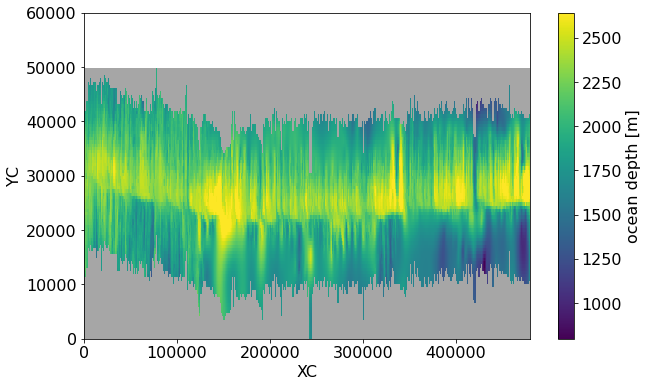

In [13]:
wmt_over['Depth'].sel(XC=slice(0, 800*600)).sortby(wmt.YC).plot(x="XC")
plt.ylim([0, 60e3])

#### Full domain

In [14]:
wmt_dict = {}

In [15]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

for label, ds in zip(['total', 'in', 'out', 'over', 'away'], [wmt, wmt_in, wmt_out, wmt_over, wmt_away]):
    wmt_dict[label] = {}
    
    mixing = ds['diff_tendency_TH'].fillna(0.)

    wmt_dict[label]['E_net'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing,
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_BBL'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing > 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_SML'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing < 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in ar

<Figure size 2160x144 with 0 Axes>

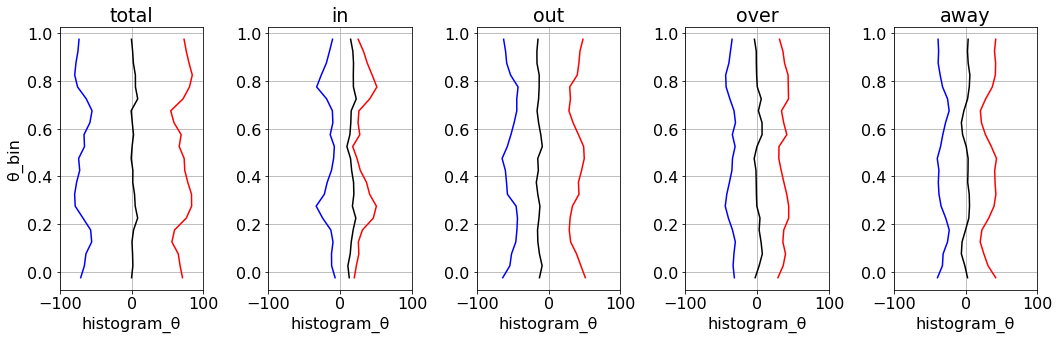

In [16]:
plt.figure(figsize=(30, 2))

colors = ['k', 'r', 'b']
fig, axes = plt.subplots(1,5, figsize=(15, 5))
for i, (key, val) in enumerate(wmt_dict.items()):
    for j, (contr, da) in enumerate(val.items()):
        (da*1e-3).mean(dim='time').plot(y='θ_bin', ax=axes[i], color=colors[j])
        
    axes[i].set_xlim(-100, 100)
    axes[i].set_title(key)
    axes[i].grid(True)
    if i>0: axes[i].set_ylabel(""); axes[i].set_yticklabels;
    
plt.tight_layout()

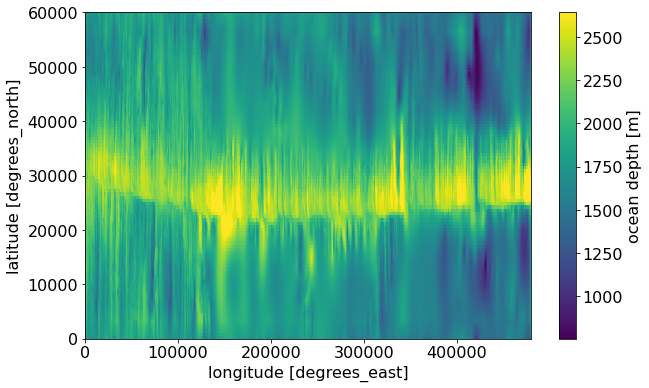

In [17]:
temp['Depth'].plot()

<a list of 3 text.Text objects>

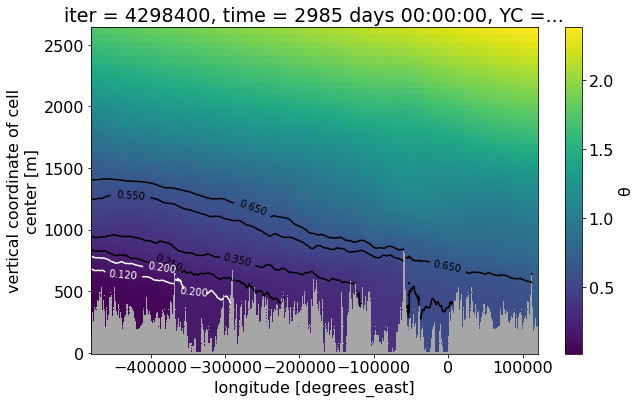

In [18]:
wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot()
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.25, 0.35], colors='k')
plt.clabel(q, inline=1, fontsize=10)
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.55, 0.65], colors='k')
plt.clabel(q, inline=1, fontsize=10)
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.12, 0.2], colors='w')
plt.clabel(q, inline=1, fontsize=10)